In [6]:
from pytorch_lightning import seed_everything
seed_everything(42)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from causaldag import partial_correlation_suffstat, partial_correlation_test, MemoizedCI_Tester, gsp, pcalg, hsic_test, kci_test

from fci import fci
from ccpg import ccpg

Seed set to 42


In [7]:
file = './real-data/airfoil-self-noise.continuous.txt'
samples = np.loadtxt(file, skiprows=1)
nnodes = samples.shape[1]

In [8]:
with open(file, 'r') as f:
    names = f.readline().strip().split('\t')

In [9]:
# run ccpg
suffstat = partial_correlation_suffstat(samples)
ci_tester = MemoizedCI_Tester(partial_correlation_test, suffstat, alpha=1e-3)

c, e = ccpg(set(range(nnodes)), ci_tester, verbose=False)
print('components', [{names[j] for j in i} for i in c])
print('edges', e)

components [{'Chord'}, {'Velocity'}, {'Displacement', 'Pressure', 'Frequency', 'Attack'}]
edges {(0, 2), (1, 2)}


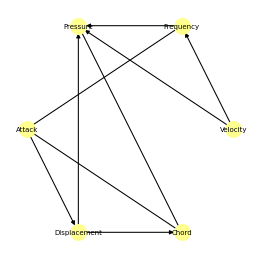

In [11]:
# run pc

est_dag = pcalg(set(range(nnodes)), ci_tester)

est_arcs = set()
est_edges = set()
for (i,j) in est_dag.arcs:
    if (names[j], names[i]) in est_arcs:
        est_edges.add(frozenset({names[j], names[i]}))
        est_arcs.remove((names[j], names[i]))
    else:
        est_arcs.add((names[i], names[j]))

G = nx.DiGraph(
    est_arcs
)

E = nx.Graph(est_edges)

plt.figure(figsize=(5, 5), dpi=50)
pos = nx.circular_layout(G)
nx.draw(
    E, pos=pos, node_color='w',linewidths=2.0, width=1.5
)
nx.draw(
    G,
    arrowsize=12,
    with_labels=True,
    node_size=500,
    node_color="#ffff8f",
    linewidths=2.0,
    width=1.5,
    font_size=10,
    pos = pos
)